In [125]:
from uproot_io import Events, View
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt
titlesize = 20
labelsize = 14

In [126]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [171]:
random_numbers = np.random.randint(0, max(events.event_number), 2500)

In [172]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def inlierplot(event_number):
    idx = np.where(events.event_number == event_number)[0]
    resis = []
    gradients = []
    intercepts = []
    particleType = []
    
    xmax = -1000
    xmin = 1000
    zmax = -1000
    zmin = 1000
    for i in idx:
        x0 = events.reco_hits_x_w[i]
        z0 = events.reco_hits_w[i]
        if len(x0) > 0:
            if max(x0) >= xmax:
                xmax = max(x0)
            if min(x0) <= xmin:
                xmin = min(x0)
        if len(z0) > 0:
            if max(z0) >= zmax:
                zmax = max(z0)
            if min(z0) <= zmin:
                zmin = min(z0)

    xlen = 0.1*(xmax - xmin)
    zlen = 0.1*(zmax - zmin)
    
    for i in idx:
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        
        particleType.append(pdg)
        if pdg == 0:
            gradients.append(0)
            intercepts.append(0)
            resis.append(0)
        
        else:
            best_inliers = []
            best_model = None
            sample_size = 10
            max_iterations = 100
            #inlier_threshold = 2.0

            for _ in range(max_iterations):
                sample_size = min(sample_size, len(x))
                sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
                x_sample = x[sample_indices]
                z_sample = z[sample_indices]

                m, c = fit_line(x_sample, z_sample)
                residuals = calculate_residuals(x, z, m, c)
                inliers = np.where(residuals < (0.15*xlen))[0]

                if len(inliers) > len(best_inliers):
                    best_inliers = inliers
                    best_model = (m, c)

            if len(best_inliers) > 0:
                m, c = best_model
                gradients.append(m)
                intercepts.append(c)
                resis.append(1)

            else:
                gradients.append(0)
                intercepts.append(0)
                resis.append(0)
    
    return np.array(np.stack((gradients, intercepts, resis, particleType)))

In [173]:
import math
#all 0 = unimportant particle
#all 1 = failed fit

def coords(event_number):
    array = inlierplot(event_number)
    m = array[0, :]
    c = array[1, :]
    r = array[2, :]
    part = array[3, :]
    
    lall = []
    tall = []
    ratio = []
    
    #print(part)
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        if part[i] != 0 and r[i] != 0:
            x = events.reco_hits_x_w[i+idx[0]]
            z = events.reco_hits_w[i+idx[0]]
            purity = events.purity[i]
            complete = events.completeness[i]
            
            if purity > 0.75 and complete > 0.75:
                if len(x) > 5:
                    znew = z - c[i]

                    angle = -math.atan(m[i])

                    l = x * np.cos(angle) - znew * np.sin(angle)
                    t = x * np.sin(angle) + znew * np.cos(angle)

                    lall.append(l)
                    tall.append(t)
                    #plt.scatter(l,t)

                    tdiff = np.abs(max(t)-min(t))
                    #ldiff = np.abs(max(l)-min(l))

                    margin = tdiff*0.05
                    inside = [x for x in t if x <= margin and x >= -margin]
                    ratio.append(len(inside)/len(t))
    
    newpart = part[part != 0]
    
    return newpart, ratio

In [174]:
def ratiohistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
        
    for n in random_numbers:
        part, vol = coords(n)
        for i in range(len(vol)):
            #if sd[i] != 0. and sd[i] != -0. and total[i] <= 20:
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(vol[i])
                snumber.append(n)
                sindex.append(i)
            else:
                tracks.append(vol[i])
                tnumber.append(n)
                tindex.append(i)
    
    #print(max(showers))
    bin_edges = np.arange(0, 1.05, 0.05)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Ratio of particles close to fitted line')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

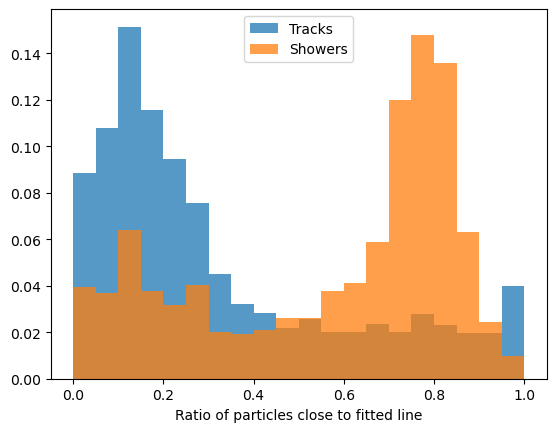

In [175]:
sh1, sn1, si1, tr1, tn1, ti1 = ratiohistplot()

In [176]:
def connectiondist(event_number):
    totals = []
    parts = []
    
    idx = np.where(events.event_number == event_number)[0]
    newidx = idx - idx[0]
    for i in newidx:
        x = events.reco_hits_x_w[i+idx[0]]
        z = events.reco_hits_w[i+idx[0]]
        part = events.mc_pdg[i+idx[0]]
        purity = events.purity[i+idx[0]]
        complete = events.completeness[i+idx[0]]
        
        if part != 0:
            if purity > 0.75 and complete > 0.75:
                if (len(x)-1) != 0:
                    total_distance = 0.0
                    for j in range(len(x) - 1):
                        distance = np.sqrt((x[j+1] - x[j])**2 + (z[j+1] - z[j])**2)
                        total_distance += distance
                    meandist = total_distance/(len(x)-1)
                    totals.append(meandist)
                    parts.append(part)
    
    return np.array(totals), np.array(parts)

In [177]:
def connecthistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
    
    for n in random_numbers:
        total, part = connectiondist(n)
        for i in range(len(total)):
            if total[i] != 0. and total[i] != -0. and total[i] <= 20:
                if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                    showers.append(total[i])
                    snumber.append(n)
                    sindex.append(i)
                else:
                    tracks.append(total[i])
                    tnumber.append(n)
                    tindex.append(i)
    
    #newshowers = [x for x in showers if x > 2]
    
    bin_edges = np.arange(0, 15.5, 0.5)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.5, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.5, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Mean Connection Distance')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

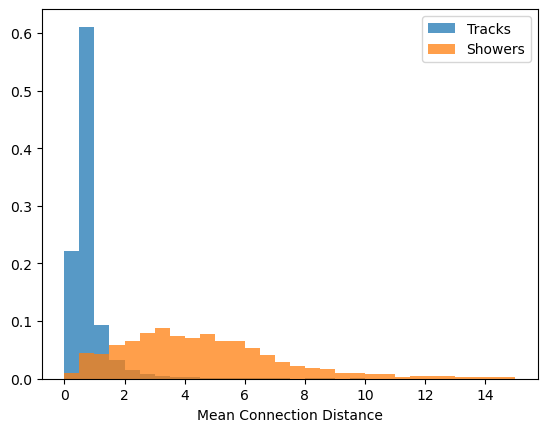

In [178]:
sh2, sn2, si2, tr2, tn2, ti2 = connecthistplot()

In [179]:
def energy(event_number):
    """needs to return energy in last X% over total energy"""
    
    particleType = np.array([])
    E = np.array([])
    
    idx = np.where(events.event_number == event_number)[0]
    
    for i in idx:
        
        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        adc = events.reco_adcs_w[i]        
        purity = events.purity[i]
        complete = events.completeness[i]
        
        # Discarding particles with no hits
        if x.size <= 5:
            None
        
        if purity <= 0.75 or complete <= 0.75:
            None
        
        else:
            
            # Get the last 30% of the energy data
            percent = int(0.8 * len(adc))
            X = adc[percent:]
            Xsum = np.sum(X)
            
            total = np.sum(adc)
            result = Xsum / total
            
            if result != 1.0:
                
                E = np.append(E, result)

                # Finding the particle type
                pdg = events.mc_pdg[i]
                particleType = np.append(particleType, pdg) 
            
    return E, particleType

In [180]:
def energyhistplot():
    tracks = []
    showers = []
    tnumber = []
    snumber = []
    tindex = []
    sindex = []
    dodgy = []
    
    for n in random_numbers:
        vol, part = energy(n)
        for i in range(len(vol)):
            if vol[i] >= 0.9:
                dodgy.append(vol[i])
            if part[i] == 22. or part[i] == -11. or part[i] == 11.:
                showers.append(vol[i])
                snumber.append(n)
                sindex.append(i)
            else:
                tracks.append(vol[i])
                tnumber.append(n)
                tindex.append(i)
    
    print(dodgy)
    bin_edges = np.arange(0, 1.05, 0.05)
    hist1, _ = np.histogram(tracks, bins=bin_edges)
    hist2, _ = np.histogram(showers, bins=bin_edges)
   
    hist1_normalized = hist1 / len(tracks)
    hist2_normalized = hist2 / len(showers)

    plt.bar(bin_edges[:-1], hist1_normalized, width=0.05, align='edge', alpha=0.75, label='Tracks')
    plt.bar(bin_edges[:-1], hist2_normalized, width=0.05, align='edge', alpha=0.75, label='Showers')
    
    plt.xlabel('Energy in last X%')
    plt.legend()
    plt.show()
    
    showers = np.array(showers)
    snumber = np.array(snumber)
    sindex = np.array(sindex)
    tracks = np.array(tracks)
    tnumber = np.array(tnumber)
    tindex = np.array(tindex)
    
    ssorted = np.argsort(showers)
    showers = showers[ssorted]
    snumber = snumber[ssorted]
    sindex = sindex[ssorted]
    
    tsorted = np.argsort(tracks)
    tracks = tracks[tsorted]
    tnumber = tnumber[tsorted]
    tindex = tindex[tsorted]
        
    return showers, snumber, sindex, tracks, tnumber, tindex

C:\Users\andre\AppData\Local\Temp\ipykernel_10596\3482831664.py:32: RuntimeWarning: invalid value encountered in scalar divide
  result = Xsum / total


[0.9441598653793335, 0.994031548500061, 0.9361642003059387, 0.9322013854980469, 0.9129627346992493, 0.9015635251998901, 0.9436172246932983, 0.9156256318092346, 0.9753686189651489, 0.9280202984809875, 0.9175810217857361, 0.9681816697120667, 0.9385757446289062, 0.9861671328544617, 0.9288393259048462, 0.9168829917907715, 0.918029248714447, 0.9268588423728943, 0.9521281719207764, 0.9430749416351318, 0.9785158634185791, 0.9008892178535461, 0.9377292990684509, 0.9169905185699463, 0.969053328037262, 0.9085462093353271, 0.9565024375915527, 0.9606032371520996, 0.940453052520752, 0.9293711185455322, 0.9313927292823792, 0.9023395776748657, 0.9153848886489868, 0.9058992266654968, 0.9544713497161865, 0.9778916835784912, 0.9744755625724792, 0.9679797887802124, 0.9304174780845642, 0.9372420907020569, 0.9429539442062378, 0.9618231058120728, 0.9108505845069885, 0.9262014031410217, 0.9595273733139038, 0.9078589081764221, 0.900550901889801, 0.9205499887466431, 0.9595273733139038, 0.9719105362892151, 0.97

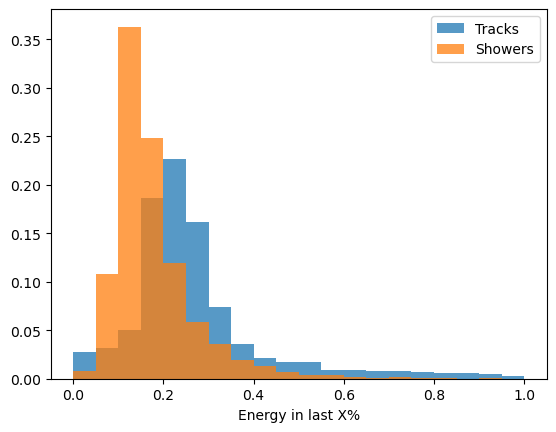

In [181]:
sh3, sn3, si3, tr3, tn3, ti3 = energyhistplot()

In [182]:
def correlationmatrix(num):
    if num == 1:
        array1 = np.column_stack((np.array([sn1, si1, sh1])))
        array2 = np.column_stack((np.array([sn2, si2, sh2])))
        array3 = np.column_stack((np.array([sn3, si3, sh3])))
    
    if num == 0:
        array1 = np.column_stack((np.array([tn1, ti1, tr1])))
        array2 = np.column_stack((np.array([tn2, ti2, tr2])))
        array3 = np.column_stack((np.array([tn3, ti3, tr3])))
    
    # Extract unique event number-particle index combinations from each array
    set1 = set(map(tuple, array1[:, :2]))
    set2 = set(map(tuple, array2[:, :2]))
    set3 = set(map(tuple, array3[:, :2]))
    
    #print(sn3, si3)
    #print(array3[:, :2].size)
    #print(set3)

    # Find the common combinations
    common_combinations = set1.intersection(set2, set3)

    # Convert common combinations back to NumPy array
    common_combinations_array = np.array(list(common_combinations))

    # Filter data based on common combinations
    result1 = array1[np.isin(array1[:, :2], common_combinations_array).all(axis=1), 2]
    result2 = array2[np.isin(array2[:, :2], common_combinations_array).all(axis=1), 2]
    result3 = array3[np.isin(array3[:, :2], common_combinations_array).all(axis=1), 2]
    
    sorting_indices = np.lexsort((common_combinations_array[:, 1], common_combinations_array[:, 0]))
    result1 = result1[sorting_indices]
    result2 = result2[sorting_indices]
    result3 = result3[sorting_indices]
    
    
    print('Shower counts:', len(sn1), len(sn2), len(sn3))
    print('Track counts:', len(tn1), len(tn2), len(tn3))

    print('Final count:', len(result1))
    
    # Combine results into a single array
    combined_results = np.vstack((result1, result2, result3))

    # Transpose the array to have variables in rows and observations in columns
    #x = combined_results.T
    
    print(np.corrcoef(combined_results))

In [185]:
correlationmatrix(0)
#1 = shower, 0 = track

Shower counts: 1143 4817 4902
Track counts: 3587 13887 15297
Final count: 2959
[[1.         0.97492025 0.78842217]
 [0.97492025 1.         0.80917448]
 [0.78842217 0.80917448 1.        ]]


In [140]:
def correlationmatrix2(num):
    #array1 = np.column_stack((np.array([sn1, si1])))
    #array2 = np.column_stack((np.array([sn2, si2])))
    #array3 = np.column_stack((np.array([sn3, si3])))
    #allnum = np.concatenate((sn1, sn2, sn3))
    #allidx = np.concatenate((si1, si2, si3))
    #alll = np.column_stack((np.array([allnum, allidx])))
    #final = []
    
    #a = np.unique(alll, axis=1)
    #print(a.shape)
    
    array1 = []
    for i, val in enumerate(sn1):
        array1.append(val+(0.001*si1[i]))
    
    array2 = []
    for i, val in enumerate(sn2):
        array2.append(val+(0.001*si2[i]))
        
    array3 = []
    for i, val in enumerate(sn3):
        array3.append(val+(0.001*si3[i]))
    
    print(len(array1), len(array2), len(array3))
    
    common_values = set(array1) & set(array2) & set(array3)

    indices_array1 = [i for i, x in enumerate(array1) if x in common_values]
    indices_array2 = [i for i, x in enumerate(array2) if x in common_values]
    indices_array3 = [i for i, x in enumerate(array3) if x in common_values]

    print("Indices in array1:", indices_array1)
    print("Indices in array2:", indices_array2)
    print("Indices in array3:", indices_array3)

In [141]:
correlationmatrix2(1)

213 914 946
Indices in array1: [1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 37, 38, 40, 41, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212]
Indices in array2: [18, 51, 66, 74, 78, 79, 88, 97, 106, 111, 129, 